# Name: Phil Clarke
    
# Student ID: 23291567

In [1]:
#Importing Libraries as needed
import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

In [2]:
# Read the data into a DataFrame
df = pd.read_csv("./bank.csv")

# Section 1a Data import

In [3]:
df

age           job   marital  education default  balance housing loan  \
0     32.0    technician    single   tertiary      no      392     yes   no   
1     39.0    technician  divorced  secondary      no      688     yes  yes   
2     59.0       retired   married  secondary      no     1035     yes  yes   
3     47.0   blue-collar   married  secondary      no      398     yes  yes   
4     54.0       retired   married  secondary      no     1004     yes   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
1995  20.0       student    single        NaN      no     2785      no   no   
1996  28.0        admin.    single  secondary      no      127      no   no   
1997  81.0       retired   married    primary      no     1154      no   no   
1998  46.0      services   married    primary      no     4343     yes   no   
1999  40.0  entrepreneur   married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
0      cellular    1   apr       957         2    131         2  failure   
1      cellular    1   apr       233         2    133         1  failure   
2      cellular    1   apr       126         2    239         1  failure   
3      cellular    1   apr       274         1    238         2  failure   
4      cellular    1   apr       479         1    307         1  failure   
...         ...  ...   ...       ...       ...    ...       ...      ...   
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
0            no  
1            no  
2            no  
3            no  
4            no  
...         ...  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes  

[2000 rows x 17 columns]

# Section 1b Creating the Column Transformers

In this section I create the column transformers required to prepare the data. To work on this, I have assessed what was done in Etivity 1 and used those learnings, this is not replicated here.  I have also not included any visualisations of the data as that was in the EDA in Etivity 1.



I thought about the pipelines in terms of which variables required the same transformation, and which required more than one transformation.  This could either be an imputation, or scaling.  I then applied them in sequence.  This caused me some challenges at the beginning as I initially went with custom transformers for all pipeline phases, and debugging became a challenge.  I revisited later in week 2 and was able develop the pipeline one change at a time to ensure it was working in each step and debug as I went.  I also substitued any customer transformers I could with standard transformers in scikit.





In [4]:
#This is the only custom transformer needed as all others are built from libraries
def balance_transformer(X):
    return pd.DataFrame(np.log(X['balance'] + abs(min(X['balance'])) + 1), columns=['balance']) #divided by ten to allign scales

#These are the standard functions - the purpose here was to list out the transformers

ohe = OneHotEncoder(sparse_output=False, drop='first')
ode= OrdinalEncoder()
simpute = SimpleImputer(strategy='most_frequent')
Sscale = StandardScaler() #I used this on age and have moved between standard -/+ to min max (all positive) in the end staying on standard
rscale = RobustScaler()
numimpute = SimpleImputer(strategy='median') #I had to simplify this to the median value, ideally I would have use a groupby replacement related to jobrole but median is acceptable to the numbers involved
unknown = SimpleImputer(strategy='constant', fill_value='unknown') #replacing with unkown values in cat variables
log = FunctionTransformer(balance_transformer, validate=False) #using the np.log function above on balance due to outliers


#These are all the pipelines created, including the fields they are applied to.  There may be some duplication of code here
# as I list the variable names twice, but it worked and helped clarity

#imputing the education varible and then giving it an ordinal replacement (since it was primary, secondary, tertiary ordinal auto worked)
ct0= ColumnTransformer(
    transformers=[('EduImpScl', Pipeline([('simputer', simpute),('ordinal', ode)]), ['education']), 
    ],remainder='passthrough')

#Imputing the missing age variables
ct1= ColumnTransformer(
    transformers=[('AgeimpScl', Pipeline([('numimputer', numimpute),('standsc', Sscale)]), ['age']), 
    ],remainder='passthrough')

#replacing the job contact and poutcome variables with unknown( iso NaN) and one hot encoding
ct2=ColumnTransformer(
    transformers=[('Unk', Pipeline([('unkwowns', unknown),('onehot', ohe)]), ['job','contact','poutcome']), 
    ],remainder='passthrough')

#robust scaling the duration and pdays 
ct3=ColumnTransformer(
    transformers=[('RobScl', Pipeline([('robust', rscale)]), ['duration','pdays']), 
    ],remainder='passthrough')

#using the custom function to deal with balance with high outliers
ct4 = ColumnTransformer(
    transformers=[
        ('BalScl',log, ['balance'])
    ],
    remainder='passthrough')

#onehot encoding the remainder
ct5=ColumnTransformer(
    transformers=[('OneHot', Pipeline([('onehotencode', ohe)]), ['subscribed', 'month','marital','default','housing','loan']), 
    ],remainder='passthrough')




# Section 1c Creating the preprocessing pipeline

In [5]:
#my preprocessor is a columntransformer that applies the above pipe to the original df.

preprocessor = ColumnTransformer(
    transformers=[
        ('ct0', ct0, ['education']),
        ('ct1', ct1, ['age']),
        ('ct2', ct2, ['job','contact','poutcome']),
        ('ct3', ct3, ['duration','pdays']),
        ('ct4', ct4, ['balance']),
        ('ct5', ct5, ['subscribed', 'month','marital','default','housing','loan']),
        ('drop_day', 'drop', ['day', 'subscribed'])  #dropping subscribed as it is a target varible and as it is balanced might cause clustering inappropriately
        
    ],
    remainder='passthrough')

joblib.dump(preprocessor, 'My_column_transformer.pkl')  #saving the preprocessor which is the point of the pipelines

preprocessor.set_output(transform="pandas")

C:\Users\filcl\anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:340: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('ct0',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('EduImpScl',
                                                                  Pipeline(steps=[('simputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('ordinal',
                                                                                   OrdinalEncoder())]),
                                                                  ['education'])]),
                                 ['education']),
                                ('ct1',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('AgeimpScl',
                                                                  Pipeline(s...
                                                                  ['balance'])]),
                                 ['balance']),
                                ('ct5',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('OneHot',
                                                                  Pipeline(steps=[('onehotencode',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse_output=False))]),
                                                                  ['subscribed',
                                                                   'month',
                                                                   'marital',
                                                                   'default',
                                                                   'housing',
                                                                   'loan'])]),
                                 ['subscribed', 'month', 'marital', 'default',
                                  'housing', 'loan']),
                                ('drop_day', 'drop', ['day', 'subscribed'])])

In [6]:
#creating a processed dataframe scaled, imputed, with day dropped resulting in 40 columns.
Processeddf=preprocessor.fit_transform(df)

In [7]:
Processeddf #don't like the column name format but at least it confirms what they are.


ct0__EduImpScl__education  ct1__AgeimpScl__age  \
0                           2.0            -0.767012   
1                           1.0            -0.215233   
2                           1.0             1.361277   
3                           1.0             0.415371   
4                           1.0             0.967150   
...                         ...                  ...   
1995                        1.0            -1.712918   
1996                        1.0            -1.082314   
1997                        0.0             3.095439   
1998                        0.0             0.336546   
1999                        1.0            -0.136408   

      ct2__Unk__job_blue-collar  ct2__Unk__job_entrepreneur  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           1.0                         0.0   
4                           0.0                         0.0   
...                         ...                         ...   
1995                        0.0                         0.0   
1996                        0.0                         0.0   
1997                        0.0                         0.0   
1998                        0.0                         0.0   
1999                        0.0                         1.0   

      ct2__Unk__job_housemaid  ct2__Unk__job_management  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                       0.0   
...                       ...                       ...   
1995                      0.0                       0.0   
1996                      0.0                       0.0   
1997                      0.0                       0.0   
1998                      0.0                       0.0   
1999                      0.0                       0.0   

      ct2__Unk__job_retired  ct2__Unk__job_self-employed  \
0                       0.0                          0.0   
1                       0.0                          0.0   
2                       1.0                          0.0   
3                       0.0                          0.0   
4                       1.0                          0.0   
...                     ...                          ...   
1995                    0.0                          0.0   
1996                    0.0                          0.0   
1997                    1.0                          0.0   
1998                    0.0                          0.0   
1999                    0.0                          0.0   

      ct2__Unk__job_services  ct2__Unk__job_student  ...  \
0                        0.0                    0.0  ...   
1                        0.0                    0.0  ...   
2                        0.0                    0.0  ...   
3                        0.0                    0.0  ...   
4                        0.0                    0.0  ...   
...                      ...                    ...  ...   
1995                     0.0                    1.0  ...   
1996                     0.0                    0.0  ...   
1997                     0.0                    0.0  ...   
1998                     1.0                    0.0  ...   
1999                     0.0                    0.0  ...   

      ct5__OneHot__month_nov  ct5__OneHot__month_oct  ct5__OneHot__month_sep  \
0                        0.0                     0.0                     0.0   
1                        0.0                     0.0                     0.0   
2                        0.0                     0.0                     0.0   
3                        0.0                     0.0                     0.0   
4                        

In [8]:
Processeddf.to_csv('transformed_data.csv', index=False) #wrote to CSV so I could view it outside of python

# Section 1 Review

__Task 1
Open a new Jupyter notebook and name it etivity2.ipynb. In this notebook, create a data preparation pipeline that applies the same kind of transformations that you applied as part of e-tivity 1. It is OK to leave some of the transformations outside the pipeline but aim at including as many transformations as you can within the pipeline. Follow the notebook Tutorial 2 - Clustering and Manifold Learning.ipynb as an example.__

__Done__ I have applied the pipelines to preprocess the data and make it repeatable, reducing code in the future and saved it.  I introduced most of the transforms from Etivity 1, or replaced one, such as age, with a inbuilt transformer from scikit learn.


# Section 2a K-Means - assessment of k

In this section, I will apply K-Means clustering to the preprocessed dataset, firstly I need to determine the appropriate number of clusters.  as the data is in 49 dimension space it is hard to visusalise how many clusters are needed so ML methods are required.  I will use 3 methods here (2 are asked for - Elbow using WSSC, Silhouette and Calinkski Harabasz.

In [9]:
os.environ["OMP_NUM_THREADS"] = "14"  #getting memory leak warnings with knn so set to 14 threads - no difference made however.


WSSC = []  #setting an empty list to store the inertia or wssc distances
for n_clusters in range(1, 21):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20) #20 interations to stable
    kmeans.fit(Processeddf)
    WSSC.append(kmeans.inertia_)


sil = [] #empty list to store the silhouettte scores
values_of_k = range(2, 21)
for n_clusters in values_of_k:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    kmeans.fit(Processeddf)
    sil_score = silhouette_score(Processeddf, kmeans.labels_)
    sil.append(sil_score)   
    

calinski_scores = [] #empty list to store the calinski scores
values_of_k = range(2, 21)
for n_clusters in values_of_k:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    kmeans.fit(Processeddf)
    score = calinski_harabasz_score(Processeddf, kmeans.labels_)
    calinski_scores.append(score)   
    




C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

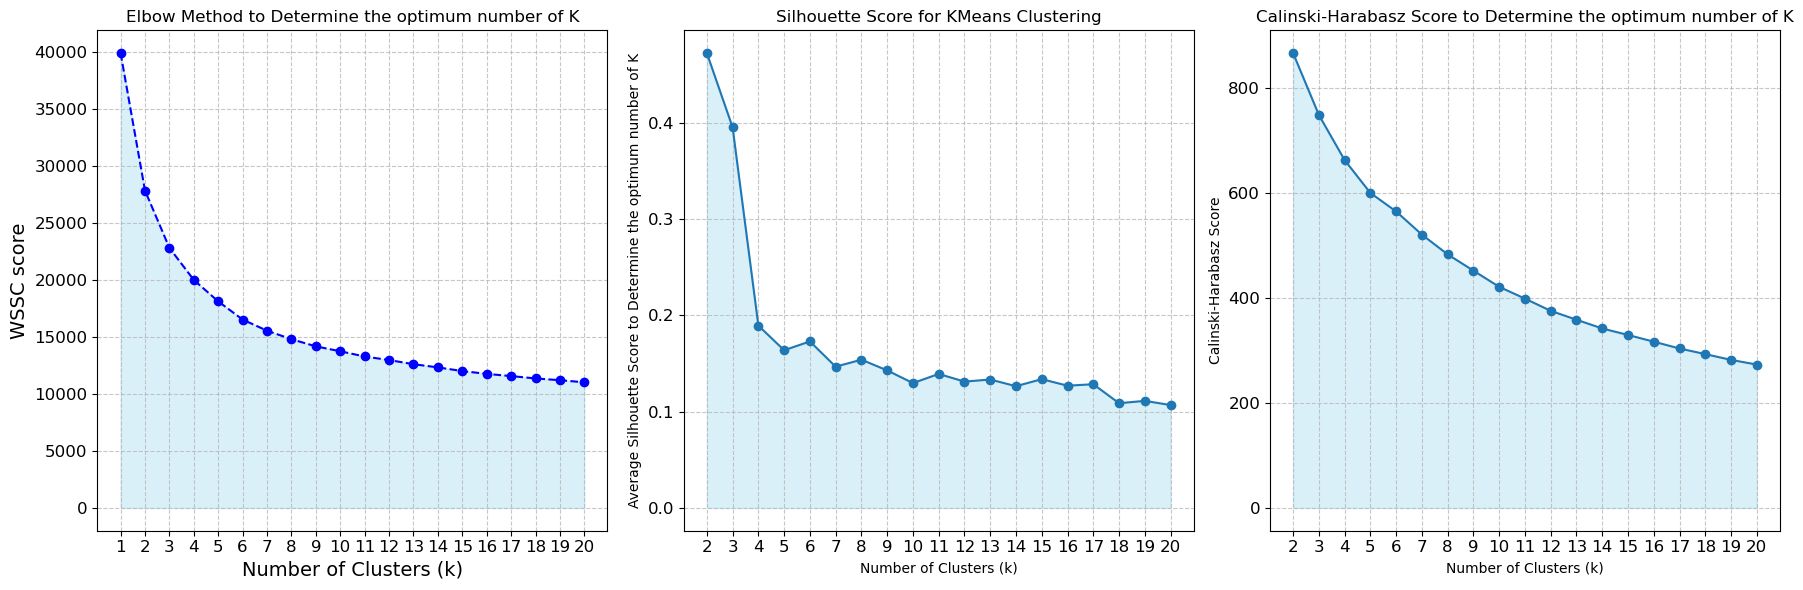

In [10]:
#Plotting the scores side by side to assess

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Elbow Method
axs[0].plot(range(1, 21), WSSC, marker='o', linestyle='--', color='b')
axs[0].fill_between(range(1, 21), WSSC, color='skyblue', alpha=0.3)
axs[0].set_title('Elbow Method to Determine the optimum number of K')
axs[0].set_xlabel('Number of Clusters (k)', fontsize=14)
axs[0].set_ylabel('WSSC score', fontsize=14)
axs[0].set_xticks(range(1, 21))
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid(True)

# Silhouette Score
axs[1].plot(values_of_k, sil, marker='o', linestyle='-')
axs[1].fill_between(values_of_k, sil, color='skyblue', alpha=0.3)
axs[1].set_xticks(values_of_k)
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Average Silhouette Score to Determine the optimum number of K')
axs[1].set_title('Silhouette Score for KMeans Clustering')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# Calinski-Harabasz Score
axs[2].plot(values_of_k, calinski_scores, marker='o', linestyle='-')
axs[2].fill_between(values_of_k, calinski_scores, color='skyblue', alpha=0.3)
axs[2].set_xticks(values_of_k)
axs[2].set_xlabel('Number of Clusters (k)')
axs[2].set_ylabel('Calinski-Harabasz Score')
axs[2].set_title('Calinski-Harabasz Score to Determine the optimum number of K')
axs[2].grid(True, linestyle='--', alpha=0.7)
axs[2].tick_params(axis='x', labelsize=12)
axs[2].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

From the Above plots, either k=2 or k=3 is a possible value of k to explore as the is the approximate elbow point of the within cluster sum of squares.  The silhouette scores on the processeddf suggest that 2 or 3 are possible selections for cluster size (noting that >.5 is typically held as a good value), with 2 being the first choice.  The calinski-harabasz method suggests that 2 clusters produces the best score.

However, to further refine the data and clusters, I want to drop out variables so I focus on only those that relate to the potential customers and not those that refer to activities of the campaign.  Not really an ML concern directly but would be in business. 

In [11]:
column_names = Processeddf.columns.tolist()
print(column_names)

['ct0__EduImpScl__education', 'ct1__AgeimpScl__age', 'ct2__Unk__job_blue-collar', 'ct2__Unk__job_entrepreneur', 'ct2__Unk__job_housemaid', 'ct2__Unk__job_management', 'ct2__Unk__job_retired', 'ct2__Unk__job_self-employed', 'ct2__Unk__job_services', 'ct2__Unk__job_student', 'ct2__Unk__job_technician', 'ct2__Unk__job_unemployed', 'ct2__Unk__job_unknown', 'ct2__Unk__contact_telephone', 'ct2__Unk__contact_unknown', 'ct2__Unk__poutcome_other', 'ct2__Unk__poutcome_success', 'ct2__Unk__poutcome_unknown', 'ct3__RobScl__duration', 'ct3__RobScl__pdays', 'ct4__BalScl__balance', 'ct5__OneHot__subscribed_yes', 'ct5__OneHot__month_aug', 'ct5__OneHot__month_dec', 'ct5__OneHot__month_feb', 'ct5__OneHot__month_jan', 'ct5__OneHot__month_jul', 'ct5__OneHot__month_jun', 'ct5__OneHot__month_mar', 'ct5__OneHot__month_may', 'ct5__OneHot__month_nov', 'ct5__OneHot__month_oct', 'ct5__OneHot__month_sep', 'ct5__OneHot__marital_married', 'ct5__OneHot__marital_single', 'ct5__OneHot__default_yes', 'ct5__OneHot__hous

In [12]:
reduceddf=Processeddf[['ct0__EduImpScl__education',  'ct1__AgeimpScl__age', 
                        'ct2__Unk__job_blue-collar', 
                        'ct2__Unk__job_entrepreneur',  'ct2__Unk__job_housemaid', 
                        'ct2__Unk__job_management',  'ct2__Unk__job_retired', 
                        'ct2__Unk__job_self-employed',  'ct2__Unk__job_services', 
                        'ct2__Unk__job_student',  'ct2__Unk__job_technician',
                        'ct2__Unk__job_unemployed',  'ct2__Unk__job_unknown',
        'ct4__BalScl__balance',          
       'ct5__OneHot__marital_married',
       'ct5__OneHot__marital_single','ct5__OneHot__default_yes',
       'ct5__OneHot__housing_yes',
       'ct5__OneHot__loan_yes']]

In [13]:
reduceddf # down to 19 dimensions

ct0__EduImpScl__education  ct1__AgeimpScl__age  \
0                           2.0            -0.767012   
1                           1.0            -0.215233   
2                           1.0             1.361277   
3                           1.0             0.415371   
4                           1.0             0.967150   
...                         ...                  ...   
1995                        1.0            -1.712918   
1996                        1.0            -1.082314   
1997                        0.0             3.095439   
1998                        0.0             0.336546   
1999                        1.0            -0.136408   

      ct2__Unk__job_blue-collar  ct2__Unk__job_entrepreneur  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           1.0                         0.0   
4                           0.0                         0.0   
...                         ...                         ...   
1995                        0.0                         0.0   
1996                        0.0                         0.0   
1997                        0.0                         0.0   
1998                        0.0                         0.0   
1999                        0.0                         1.0   

      ct2__Unk__job_housemaid  ct2__Unk__job_management  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                       0.0   
...                       ...                       ...   
1995                      0.0                       0.0   
1996                      0.0                       0.0   
1997                      0.0                       0.0   
1998                      0.0                       0.0   
1999                      0.0                       0.0   

      ct2__Unk__job_retired  ct2__Unk__job_self-employed  \
0                       0.0                          0.0   
1                       0.0                          0.0   
2                       1.0                          0.0   
3                       0.0                          0.0   
4                       1.0                          0.0   
...                     ...                          ...   
1995                    0.0                          0.0   
1996                    0.0                          0.0   
1997                    1.0                          0.0   
1998                    0.0                          0.0   
1999                    0.0                          0.0   

      ct2__Unk__job_services  ct2__Unk__job_student  ct2__Unk__job_technician  \
0                        0.0                    0.0                       1.0   
1                        0.0                    0.0                       1.0   
2                        0.0                    0.0                       0.0   
3                        0.0                    0.0                       0.0   
4                        0.0                    0.0                       0.0   
...                      ...                    ...                       ...   
1995                     0.0                    1.0                       0.0   
1996                     0.0                    0.0                       0.0   
1997                     0.0                    0.0                       0.0   
1998                     1.0                    0.0                       0.0   
1999                     0.0                    0.0                       0.0   

      ct2__Unk__job_unemployed  ct2__Unk__job_unknown  ct4__BalScl__balance  \
0                          0.0                    0.0              7.224753   
1              

In [14]:
WSSC = []
for n_clusters in range(1, 21):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    kmeans.fit(reduceddf)
    WSSC.append(kmeans.inertia_)

sil2 = []
values_of_k = range(2, 21)
for n_clusters in values_of_k:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    kmeans.fit(reduceddf)
    sil_score = silhouette_score(reduceddf, kmeans.labels_)
    sil2.append(sil_score)  
    

calinski_scores = []
values_of_k = range(2, 21)
for n_clusters in values_of_k:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    kmeans.fit(reduceddf)
    score = calinski_harabasz_score(reduceddf, kmeans.labels_)
    calinski_scores.append(score)


C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

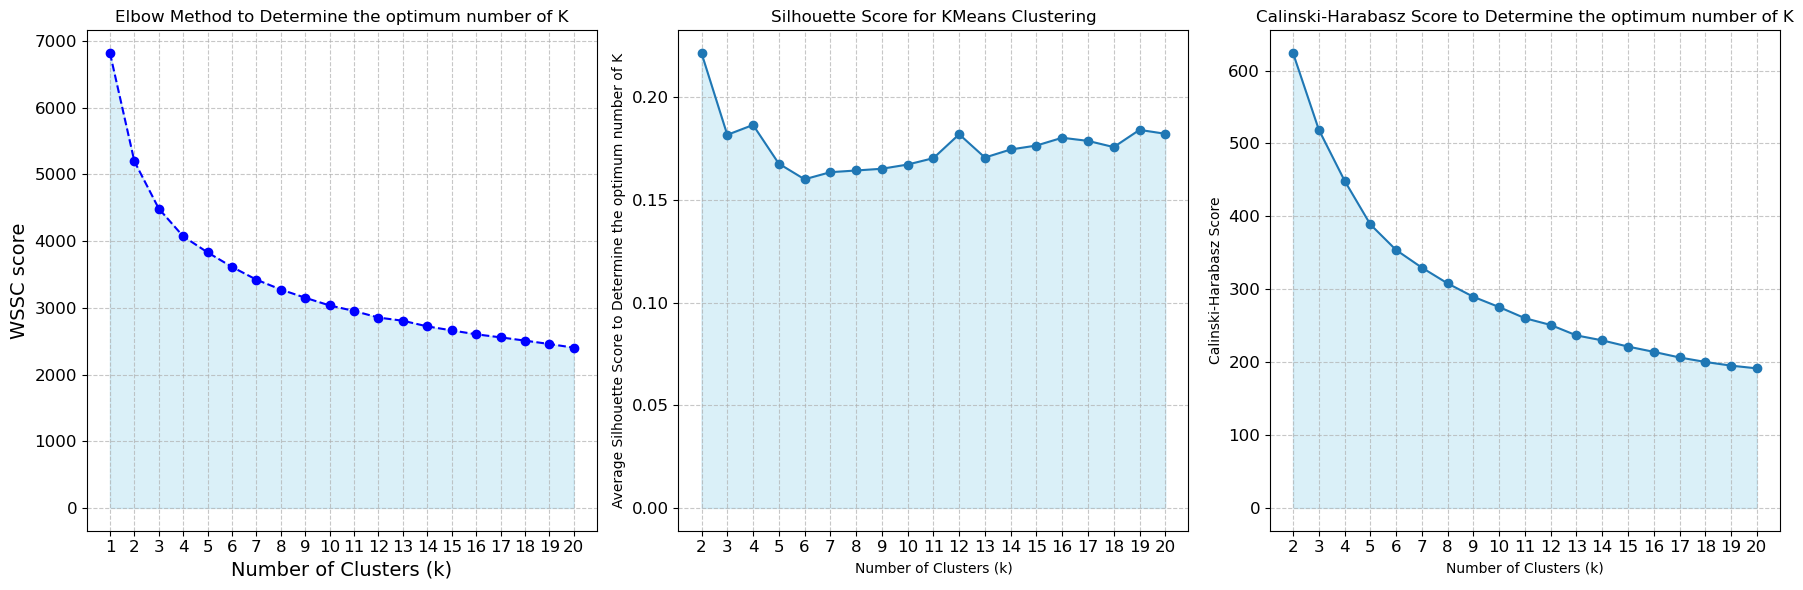

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Elbow Method
axs[0].plot(range(1, 21), WSSC, marker='o', linestyle='--', color='b')
axs[0].fill_between(range(1, 21), WSSC, color='skyblue', alpha=0.3)
axs[0].set_title('Elbow Method to Determine the optimum number of K')
axs[0].set_xlabel('Number of Clusters (k)', fontsize=14)
axs[0].set_ylabel('WSSC score', fontsize=14)
axs[0].set_xticks(range(1, 21))
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid(True)

# Silhouette Score
axs[1].plot(values_of_k, sil2, marker='o', linestyle='-')
axs[1].fill_between(values_of_k, sil2, color='skyblue', alpha=0.3)
axs[1].set_xticks(values_of_k)
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Average Silhouette Score to Determine the optimum number of K')
axs[1].set_title('Silhouette Score for KMeans Clustering')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# Calinski-Harabasz Score
axs[2].plot(values_of_k, calinski_scores, marker='o', linestyle='-')
axs[2].fill_between(values_of_k, calinski_scores, color='skyblue', alpha=0.3)
axs[2].set_xticks(values_of_k)
axs[2].set_xlabel('Number of Clusters (k)')
axs[2].set_ylabel('Calinski-Harabasz Score')
axs[2].set_title('Calinski-Harabasz Score to Determine the optimum number of K')
axs[2].grid(True, linestyle='--', alpha=0.7)
axs[2].tick_params(axis='x', labelsize=12)
axs[2].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

Adding a third assessment for the number of k clusters on the reduceddf suggests that 2 clusters are appropriate.  The Silhouette score says 2 (the highest (although still not great), the Elbow method suggests 2 or 3 and Calinski-Harabasz suggests 2 (the max).  So the majority wins and we select 2.  

# Section 2b Commentary on the Clusters

Using k = 2 from the assessment I execute the clustering with Kmeans and discuss the cluster centres

In [16]:
k = 2

# Run k-means clustering
kmeans2 = KMeans(n_clusters=k, random_state=42, n_init=20)
kmeans2.fit(reduceddf)

# Get the cluster labels
cluster_labels2 = kmeans2.labels_
cluster_center2 = kmeans2.cluster_centers_
# Add the cluster labels to the original dataframe
df['Cluster2'] = cluster_labels2

# Print the cluster centers
print("For 2 clusters")
print("Cluster centers:")
print(pd.DataFrame(kmeans2.cluster_centers_, columns=reduceddf.columns))

# Print the count of points in each cluster
print("\nCount of points in each cluster:")
print(df['Cluster2'].value_counts())

print("______________________________________________________________________________")
print("For 3 clusters")

k = 3
# Run k-means clustering
kmeans3 = KMeans(n_clusters=k, random_state=42, n_init=20)
kmeans3.fit(reduceddf)

# Get the cluster labels
cluster_labels3 = kmeans3.labels_
cluster_center3 = kmeans3.cluster_centers_
# Add the cluster labels to the original dataframe
df['Cluster3'] = cluster_labels3

# Print the cluster centers
print("Cluster centers:")
print(pd.DataFrame(kmeans3.cluster_centers_, columns=reduceddf.columns))

# Print the count of points in each cluster
print("\nCount of points in each cluster:")
print(df['Cluster3'].value_counts())

C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


For 2 clusters
Cluster centers:
   ct0__EduImpScl__education  ct1__AgeimpScl__age  ct2__Unk__job_blue-collar  \
0                   0.994294             1.118166                   0.138374   
1                   1.362587            -0.603414                   0.154734   

   ct2__Unk__job_entrepreneur  ct2__Unk__job_housemaid  \
0                    0.027104                 0.034237   
1                    0.020015                 0.008468   

   ct2__Unk__job_management  ct2__Unk__job_retired  \
0                  0.159772               0.229672   
1                  0.268668               0.000770   

   ct2__Unk__job_self-employed  ct2__Unk__job_services  ct2__Unk__job_student  \
0                     0.028531                0.061341          -3.469447e-17   
1                     0.033872                0.093918           7.390300e-02   

   ct2__Unk__job_technician  ct2__Unk__job_unemployed  ct2__Unk__job_unknown  \
0                  0.168331                  0.024251            

C:\Users\filcl\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


__Observations between the two clusters__ 
On the differences in the 2 Clusters (in reference to Cluster 1):  

    1.People in Cluster 1 are more educated which a higher ordinal score centre (1.36 v .99).
    2.They are younger with a cluster centre of -.6 as opposed to 1.1.
    3. In terms of job roles, they contain more unemployed, more students, less retirees and housemaids.  These roles had specifc age profiles in the EDA in Evivity 1.
    4. People in cluster 1 and less likely to be married, more likely to be single
    5. They are marginally more likely to have a housing loan.
    
Looking at the clusters, the age variable, and its colinearity with some of the job roles appears to be impacting the cluster allocation.


On the differences in the 3 Clusters (in reference to Cluster 1):  

    1.People in Cluster 2  are more educated which a higher ordinal score centre, cluster 1 are the least educated.
    2.people in cluster 2 are the youngest while cluster 1 are the oldest.  (cluster 0 in the middle)
    3. In terms of job roles, cluster 2 have the most students while cluster 1 has the most retirees.
    4. People in cluster 2 and less likely to be married, more likely to be single
    5. They are marginally more likely to have a housing loan in cluster 0.
    
Similar to k=2, 3 cluster leans heavily on age variables (as they are driving other factors as well (job role, education, housing loan).




# Section 2c Preparation for and execution of MDS

In [17]:
data_and_centers2 = np.r_[reduceddf, cluster_center2]
data_and_centers3 = np.r_[reduceddf, cluster_center3]

In [18]:
cc2 = pd.DataFrame(data_and_centers2)
cc3 = pd.DataFrame(data_and_centers3)# Here I have added the cluster centres to the bottom on the reduced 19 column dataframe.
cc3 #for example

0         1         2         3         4         5   \
0     2.000000 -0.767012  0.000000  0.000000  0.000000  0.000000   
1     1.000000 -0.215233  0.000000  0.000000  0.000000  0.000000   
2     1.000000  1.361277  0.000000  0.000000  0.000000  0.000000   
3     1.000000  0.415371  1.000000  0.000000  0.000000  0.000000   
4     1.000000  0.967150  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...   
1998  0.000000  0.336546  0.000000  0.000000  0.000000  0.000000   
1999  1.000000 -0.136408  0.000000  1.000000  0.000000  0.000000   
2000  1.212984 -0.180668  0.202733  0.028474  0.011390  0.236902   
2001  0.991170  1.480647  0.092715  0.026490  0.037528  0.169978   
2002  1.424514 -0.765480  0.116592  0.011958  0.011958  0.263079   

                6         7         8             9         10        11  \
0     0.000000e+00  0.000000  0.000000  0.000000e+00  1.000000  0.000000   
1     0.000000e+00  0.000000  0.000000  0.000000e+00  1.000000  0.000000   
2     1.000000e+00  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
3     0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
4     1.000000e+00  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
...            ...       ...       ...           ...       ...       ...   
1998  0.000000e+00  0.000000  1.000000  0.000000e+00  0.000000  0.000000   
1999  0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000  0.000000   
2000  4.555809e-03  0.035308  0.111617  1.138952e-03  0.203872  0.030752   
2001  3.487859e-01  0.022075  0.037528 -2.081668e-17  0.119205  0.028698   
2002 -1.249001e-16  0.034380  0.074738  1.420030e-01  0.171898  0.043348   

            12        13            14        15        16        17        18  
0     0.000000  7.224753  0.000000e+00  1.000000  0.000000  1.000000  0.000000  
1     0.000000  7.419980  0.000000e+00  0.000000  0.000000  1.000000  1.000000  
2     0.000000  7.608871  1.000000e+00  0.000000  0.000000  1.000000  1.000000  
3     0.000000  7.229114  1.000000e+00  0.000000  0.000000  1.000000  1.000000  
4     0.000000  7.593374  1.000000e+00  0.000000  0.000000  1.000000  0.000000  
...        ...       ...           ...       ...       ...       ...       ...  
1998  0.000000  8.579980  1.000000e+00  0.000000  0.000000  1.000000  0.000000  
1999  0.000000  8.907071  1.000000e+00  0.000000  0.000000  0.000000  0.000000  
2000  0.002278  7.392773  8.701595e-01  0.004556  0.009112  0.638952  0.173121  
2001  0.008830  7.764742  7.660044e-01  0.048565  0.004415  0.275938  0.101545  
2002  0.005979  7.493971 -3.330669e-16  0.968610  0.007474  0.414051  0.077728  

[2003 rows x 19 columns]

In [19]:
# Multi-Dimensional Scaling (MDS) to reduce from 19 to 2 dimensions
mds = MDS(n_components=2, dissimilarity='euclidean', random_state=42,normalized_stress=False) #normalised stress variable to remove a warning
#Have gone with Euclidean distance to determine the distance over the other options (such as manhattan) for explainability
data_2d2 = mds.fit_transform(data_and_centers2) #fitting the mds model on the data and the centers.
data_2d3 = mds.fit_transform(data_and_centers3) #fitting the mds model on the data and the centers.



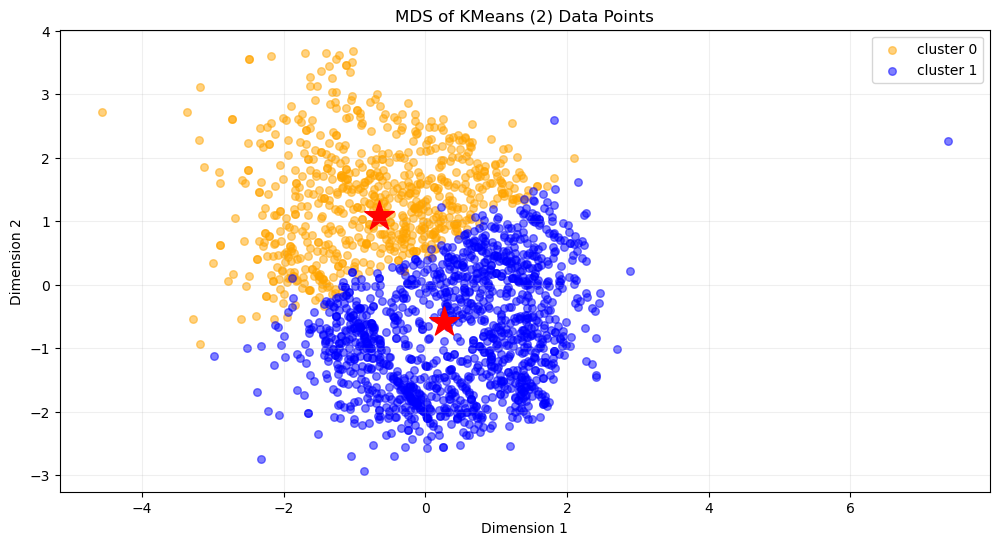

In [20]:
#Ultilising the code provided (with some changes for style to produce the mds chart)
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])
k = 2
def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    plt.figure(figsize=(12, 6))
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i),s=30,
                    alpha=0.5)

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.grid(True, alpha=0.2)
    _ = plt.xlabel('Dimension 1')
    _ = plt.ylabel('Dimension 2')

#Display the graphics
clustering_scatterplot(points=data_2d2[:-k,:], 
                       labels=kmeans2.labels_, 
                       centers=data_2d2[-k:,:], 
                       title='MDS of KMeans (2) Data Points')

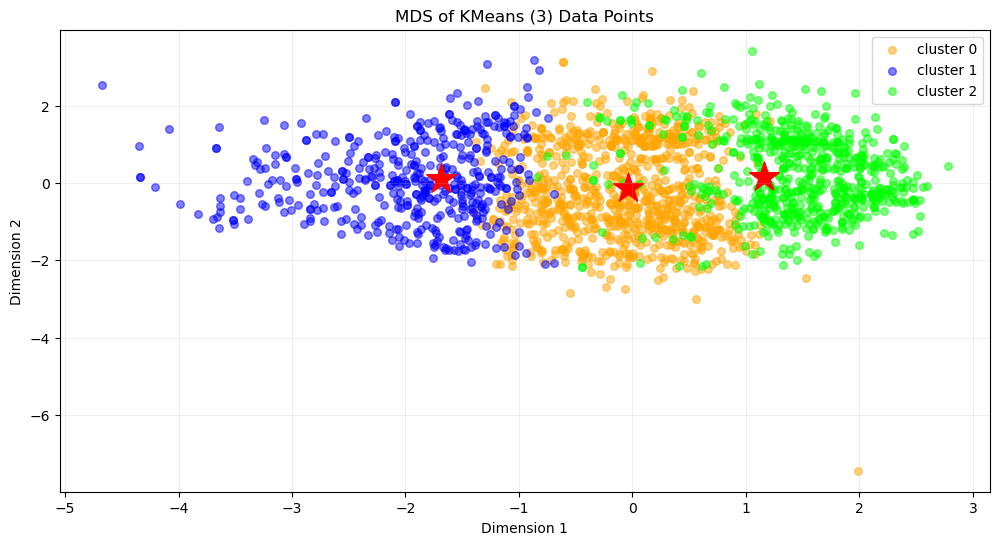

In [21]:
#Ultilising the code provided (with some changes for style to produce the mds chart)
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])
k = 3
def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    plt.figure(figsize=(12, 6))
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i),s=30,
                    alpha=0.5)

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.grid(True, alpha=0.2)
    _ = plt.xlabel('Dimension 1')
    _ = plt.ylabel('Dimension 2')

#Display the graphics
clustering_scatterplot(points=data_2d3[:-k,:], 
                       labels=kmeans3.labels_, 
                       centers=data_2d3[-k:,:], 
                       title='MDS of KMeans (3) Data Points')

# Section 2D Producing the same in T-SNE

In this section I will produce the same dimension reduction using T-SNE

In [22]:
# t-SNE
tsne = TSNE(n_components=2, metric='euclidean', random_state=42, n_iter=250, perplexity=30)
data_2d2tsne = tsne.fit_transform(data_and_centers2)
data_2d3tsne = tsne.fit_transform(data_and_centers3)

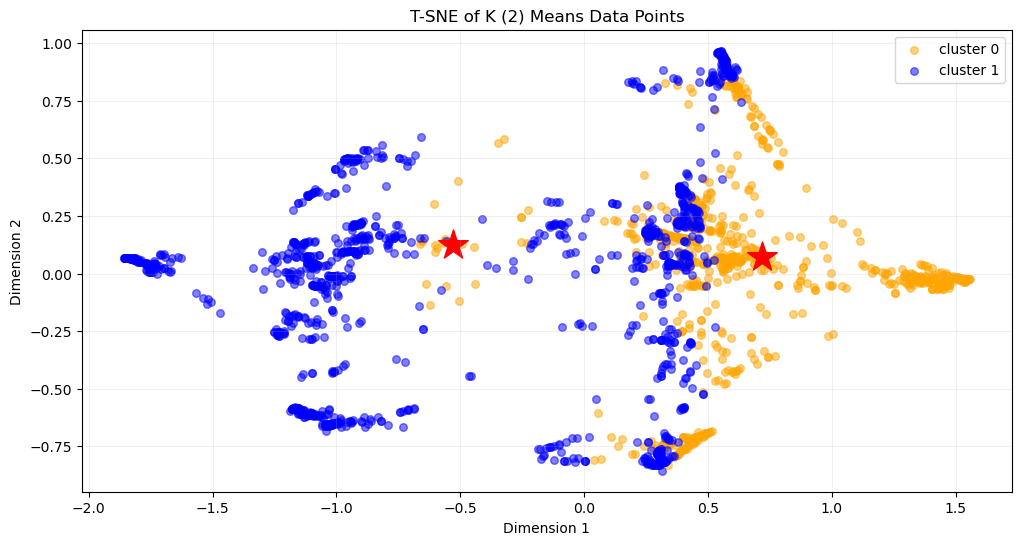

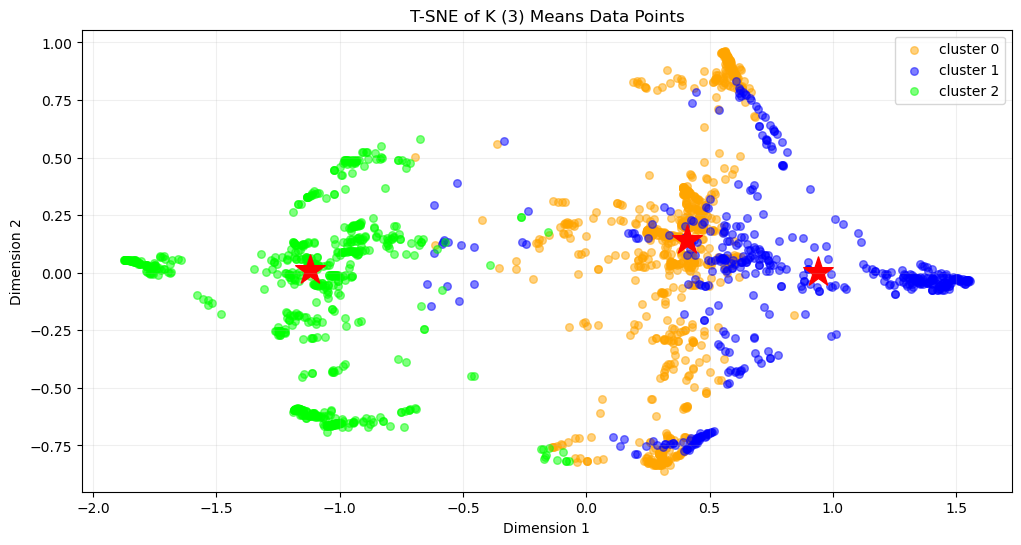

In [23]:
k=2
clustering_scatterplot(points=data_2d2tsne[:-k,:], 
                       labels=kmeans2.labels_, 
                       centers=data_2d2tsne[-k:,:], 
                       title='T-SNE of K (2) Means Data Points')
k=3
clustering_scatterplot(points=data_2d3tsne[:-k,:], 
                       labels=kmeans3.labels_, 
                       centers=data_2d3tsne[-k:,:], 
                       title='T-SNE of K (3) Means Data Points')


The MDS model has created two clusters linearly seperated.  They essentially look like a blob of points divided in two which suggests that centre points and not disalike.  The T-SNE plot appears to show a similar patterns with some blue a yellow clearly divergent while there is overlapping similarities along dimension one.

# Section 2 Review

Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.  
__Done: the WSSC  was used with the elbow method for two datasources to suggest the number of clusters to be 2 or 3.__

Use the Silhouette Coefficient method to determine the best value of k as well.  
__Done: the silhouette coeffiecient methods was used to determine the best number of clusters to be either 2 or 3.  In additional I used the CH method to confirm either 2 or 3 clusters.__

Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering. 
__Done:  Initially I produced 2 clusters however looking at the T-SNE and MDS outputs I decided to also produce 3 clusters 
which I feel made more sense in the data.__

Use MDS and t-SNE for visualising the clusterings. 
__Done:  T-SNE and MDS were used to examine the clusters in 2 dimensions__.

Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell). 
__Done in section 2b and also commented on during the work.__

# Section 3a DB Scan Clustering

# Section 3b Identifying Episilon and Min points

Before we begin DB scan(ning) we must determine some values to use for the value of min_samples (the number of samples needed to determine a core point) and epsilon, the distance or radius searching for points. 

The first value min points, we will choose 2* the dimensions (19) which will give us 38, we can then use the nearestneighbour method to determine the best value of epsilon.

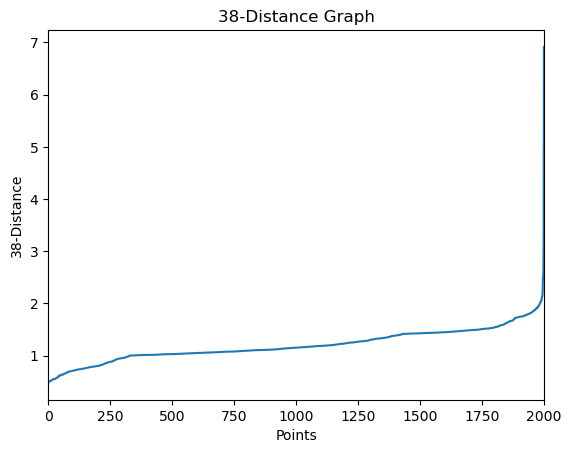

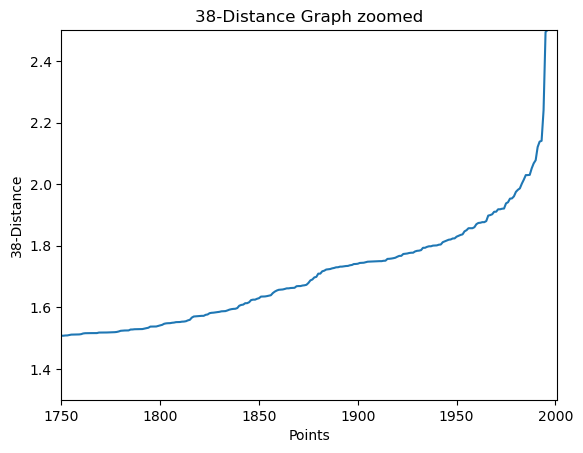

In [24]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 38 #choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).

# Fitting the Nearest Neighbors model to determine possible values of epsilon
nearest_neighbors_model = NearestNeighbors(n_neighbors=min_samples) #38
nearest_neighbors_model.fit(reduceddf)

# Compute the k-distance graph
distances, _ = nearest_neighbors_model.kneighbors(reduceddf) #on the reduced data
distances = np.sort(distances[:, -1])

# Plot the k-distance graph
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'{min_samples}-Distance')
plt.title(f'{min_samples}-Distance Graph')
plt.xlim(0,2000)
plt.show()

# Plot the k-distance graph on a zoomed axis to see more clearly
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'{min_samples}-Distance')
plt.title(f'{min_samples}-Distance Graph zoomed')
plt.xlim(1750,2001)
plt.ylim(1.3,2.5)
plt.show()
#based on the chart below I will choose a value of 1.5-2.5

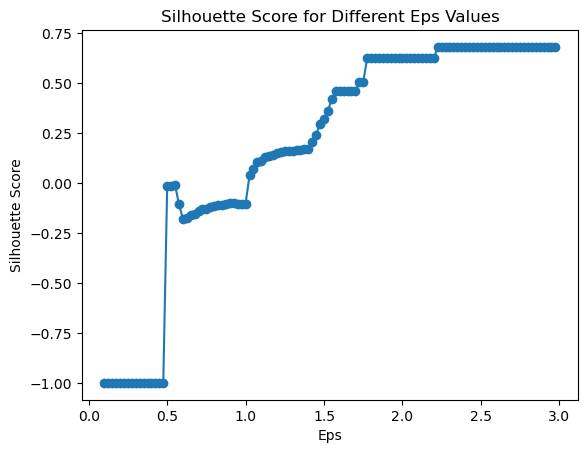

Best Eps: 2.2249999999999996


In [25]:
#using the silhouette score to help determine the eps value
from sklearn.metrics import silhouette_score

eps_values = np.arange(0.1, 3.0, 0.025) #running through a number of values
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(reduceddf)
    if len(set(dbscan.labels_)) > 1:
        silhouette_scores.append(silhouette_score(reduceddf, dbscan.labels_))
    else:
        silhouette_scores.append(-1)

best_eps = eps_values[np.argmax(silhouette_scores)]

plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Eps')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Eps Values')
plt.show()

print("Best Eps:", best_eps)

Based on the above, I would choose 38 as the min sample size for a cluster size and an epsilon value of 2.225.  The purpose here is to not nescessarily get clusters but use known methodology.  However on further work it is only 1 cluster.  So I will chose a value of 1.05 to elicit 3 clusters and noise to better understand the outputs.  But it is highly likely that 1 cluster is correct.

# Section 3c Running DB Scan

In [26]:
eps = 1.05
#Step 2: Instantiate DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples) #38 samples

# Step 3: Fit Data
dbscan.fit(reduceddf)

# Step 4: Generate Core Samples Mask
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Step 5: Extract Labels
labels = dbscan.labels_

# Step 6: Determine the Number of Clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Step 7: Calculate the Number of Noise Points
n_noise_ = list(labels).count(-1) 

print(n_clusters_)
print(n_noise_)

3
583


# Section 3d Reducing the dimensions

In [27]:
# Multi-Dimensional Scaling (MDS)
mds = MDS(n_components=2, dissimilarity='euclidean', random_state=42, normalized_stress=False)
data_2dmds = mds.fit_transform(reduceddf)
cluster_centers = np.array([reduceddf[labels == i].mean(axis=0) for i in range(n_clusters_) if i != -1])



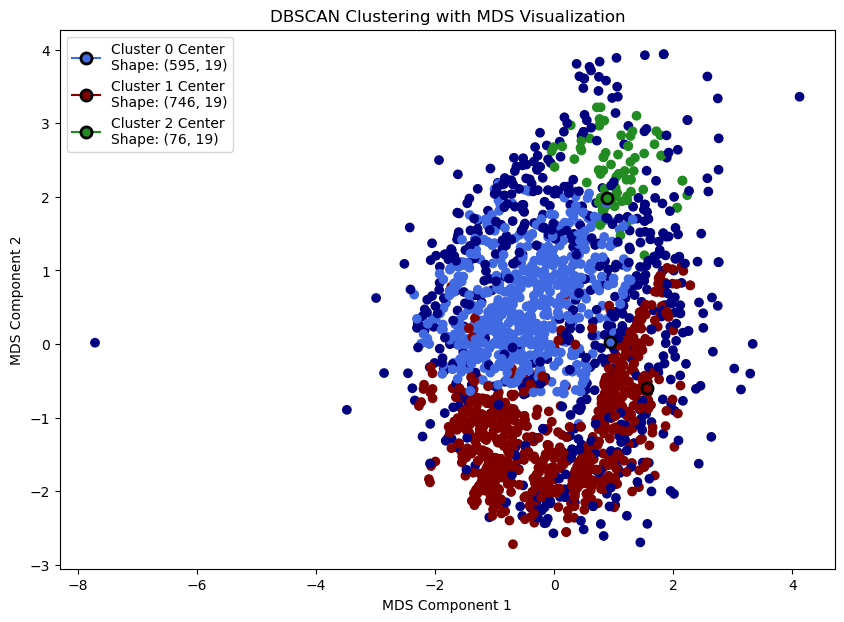

In [28]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.figure(figsize=(10, 7))
plt.scatter(data_2dmds[:, 0], data_2dmds[:, 1], c=vectorizer(labels))
plt.title('DBSCAN Clustering with MDS Visualization')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')

# Calculating the cluster centre for the plots
for cluster_label in set(labels):
    if cluster_label != -1:
        cluster_center = np.mean(reduceddf[labels == cluster_label], axis=0)
        cluster_shape = reduceddf[labels == cluster_label].shape
        plt.plot(cluster_center[0], cluster_center[1], marker='o', markersize=8, markeredgecolor='k', markeredgewidth=2, label=f'Cluster {cluster_label} Center\nShape: {cluster_shape}', color=colors[cluster_label % len(colors)])

plt.legend()
plt.show()

In [29]:
tsne = TSNE(n_components=2, metric='euclidean', random_state=42, n_iter=250, perplexity=30)
data_2dtsne = tsne.fit_transform(reduceddf)
cluster_centerstsne = np.array([reduceddf[labels == i].mean(axis=0) for i in range(n_clusters_) if i != -1])

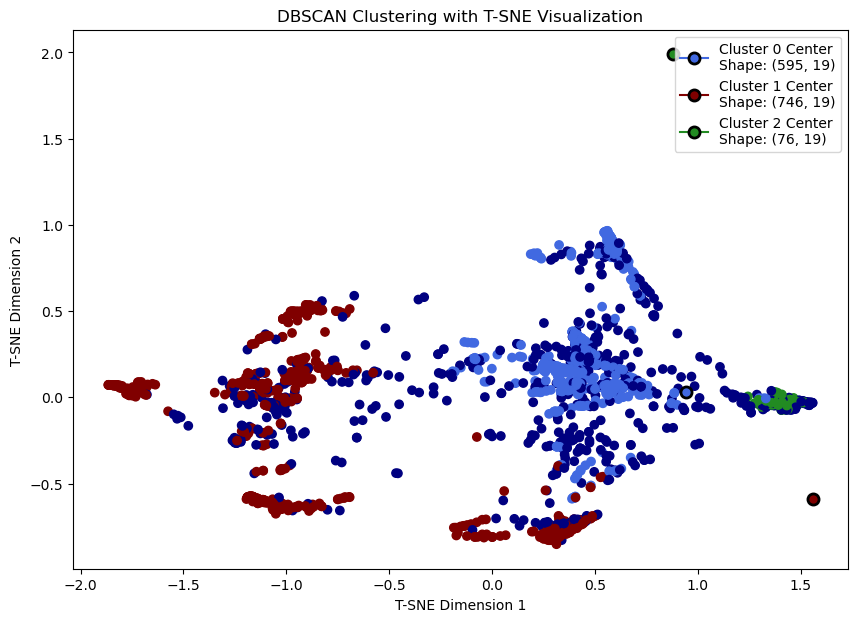

In [30]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.figure(figsize=(10, 7))
plt.scatter(data_2dtsne[:, 0], data_2dtsne[:, 1], c=vectorizer(labels))
plt.title('DBSCAN Clustering with T-SNE Visualization')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')

# Calculating and plotting cluster centers
for cluster_label in set(labels):
    if cluster_label != -1:
        cluster_center = np.mean(reduceddf[labels == cluster_label], axis=0)
        cluster_shape = reduceddf[labels == cluster_label].shape
        plt.plot(cluster_center[0], cluster_center[1], marker='o', markersize=8, markeredgecolor='k', markeredgewidth=2, label=f'Cluster {cluster_label} Center\nShape: {cluster_shape}', color=colors[cluster_label % len(colors)])

plt.legend()
plt.show()

The value of k equal to 2 or 3 clusters in k-means assumes that the data itself is not clustered in a circular spherical manner.  The three clusters in K-means are explainable however they are driven by age which scaled is still continous and offered little seperation and opportunity for pockets of density.  Many of the other factors were related to age as well.

In DB scan the recommended cluster was 1, which somewhat confirms the above point about lack of pockets of density.  Forcing 3 clusters by varying the parameters yields clusters that overlapped significantly and noise accounting for more than 25% of the data.

In hindsight perhaps technicques like binning age might have created some seperation to allow DB scan to work better, but on the base data, which was suitable for prediction in Etivity 1, we yielded not great results and clusters.

# Section 3e Review

In your notebook e-tivity2.ipynb:

Apply the DBSCAN clustering algorithm to the prepared bank dataset.

__DONE:  Identified values for eps and minimum samples using two different methods and applied that.  The DB method suggests only one cluster.  Varying the parameters I have displayed three but there is significant overlap and noise associated with them.  1 cluster may be the optimum.__

Use MDS and t-SNE for visualising the clustering. 
__DONE: Displayed the DB SCAN output in 2 dimensional space using T-SNE and MDS.__


Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell)
__DONE in section 3d__
